# Using the Fal mooring in situ data to calculate air-sea CO$_2$ gas fluxes #

## Introduction
This notebook explains how we can use the Fal mooring data to calculate air-sea CO$_2$ gas fluxes

### Load Relevant Modules
To begin with the required Python packages are loaded.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset
# Install basemap-data-hires

### Loading the mooring data
Now we need to load the mooring data which is provided as a tab separated variable file (.tsv). And we can then view the first 5 rows of the dataset using the .head(5) command. Alternatively you can view the last 5 rows of the dataset using .tail(5).

In [2]:
# Load data file
region_data = pd.read_csv('merged_draft_final.tsv', sep='\t', index_col=0)
# Show small proportion of the data
region_data.head(5)

,Lon,Lat,Datetime,Date,Year,Month,Day,Hour,Minute,Second,salinity,sstskin_c,sstskin_k,windu10,windu10_moment2,pco2sw_corr_split,pressure_met,pco2_air_noaa_2018,pco2_sst
0,-5.027979,50.216161,14/09/2018 00:00,14/09/2018,2018,9,14,0,0,0,34.417400,16.709000,289.859000,2.057613,4.233772,500.019450,1024.1,401.3573,16.642000
1,-5.027979,50.216161,14/09/2018 00:00,14/09/2018,2018,9,14,0,0,0,34.417400,16.709000,289.859000,2.057613,4.233772,488.055048,1024.1,401.3573,16.642000
2,-5.027979,50.216161,14/09/2018 01:00,14/09/2018,2018,9,14,1,0,0,34.175967,16.681167,289.831167,2.057613,4.233772,550.944840,1023.9,401.3573,16.598000
3,-5.027979,50.216161,14/09/2018 02:00,14/09/2018,2018,9,14,2,0,0,33.936400,16.606000,289.756000,2.572016,6.615269,588.035046,1023.5,401.3573,16.514667
4,-5.027979,50.216161,14/09/2018 03:00,14/09/2018,2018,9,14,3,0,0,33.718900,16.542000,289.692000,2.572016,6.615269,627.313939,1022.9,401.3573,16.463000


### Preparing to Plot the Recorded Data
We want to plot a 'time series' of the data that was recorded. One way to show this is to plot 'Days since [first recording]' along the x-axis and the data along the y-axis. The cell below finds the number of days since the first measurement (technically it finds the number of seconds since the first recording and divides this by 86,400) and creates a new column in the Dataframe to show these values.

Note: if your own dataset doesn't have columns for 'Year', 'Month', 'Day', etc. then the below won't work and you need to add this to your dataset. This can be done in Excel (but better to do it Pythonically if possible to prevent Excel making changes to it's own formatting), and see example datasets for the required format.

In [3]:
# Initialise the new Dataframe column and fill with a hold value
region_data['Days_since'] = 'hold value'

# Produce a datetime object for the first recording 
# - the zeros in the line below show it's the first row (index starts at zero)
start_date = dt.datetime(region_data.loc[0,'Year'],region_data.loc[0,'Month'],region_data.loc[0,'Day'],
                            region_data.loc[0,'Hour'],region_data.loc[0,'Minute'],region_data.loc[0,'Second'])

# Loop over all rows in the Dataframe - i.e from 0 to the length of the Dataframe
for i in range(0,len(region_data)):
    # Get the date time object for the currently indexed recording - indexed by i
    future_date = dt.datetime(region_data.loc[i,'Year'],region_data.loc[i,'Month'],region_data.loc[i,'Day'],
                              region_data.loc[i,'Hour'],region_data.loc[i,'Minute'],region_data.loc[i,'Second'])
    
    # Find difference between current datetime and inital datetime
    day_diff = future_date - start_date
    
    # Fill Dataframe column with time difference in seconds (found using .total_seconds()) 
    # divided by 86400 (proportion of days that have passed)
    region_data.loc[i,'Days_since'] = day_diff.total_seconds()/(60*60*24)

We can filter the Dataframe to show just the 'Datetime' and 'Days_since' columns. Showing the head can give an idea if the previous cell worked - although a more thorough check is advised if possible depending on Dataframe size.

In [4]:
# Filter data to 'Datetime' and 'Days_since' columns and show first 5 rows.
region_data[['Datetime', 'Days_since']].head(5)

,Datetime,Days_since
0,14/09/2018 00:00,0.0
1,14/09/2018 00:00,0.0
2,14/09/2018 01:00,0.041667
3,14/09/2018 02:00,0.083333
4,14/09/2018 03:00,0.125


### Plotting the Time Series  

The Matplotlib .subplots() function is ideal for this and I have used Seaborn to do the actual plotting - these two packages work well together as Seaborn is built on top of Matplotlib, and Seaborn also integrates easily with Pandas Dataframes. 

Producing nice looking plots with lovely axes labels and colors etc. can be fiddly, but you can refer to the documentation (and StackOverflow!) for hints and tips.

/Users/sayooj/opt/anaconda3/envs/fe_work_env/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: 
The palette list has fewer values (427) than needed (428) and will cycle, which may produce an uninterpretable plot.
  
/Users/sayooj/opt/anaconda3/envs/fe_work_env/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/sayooj/opt/anaconda3/envs/fe_work_env/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator


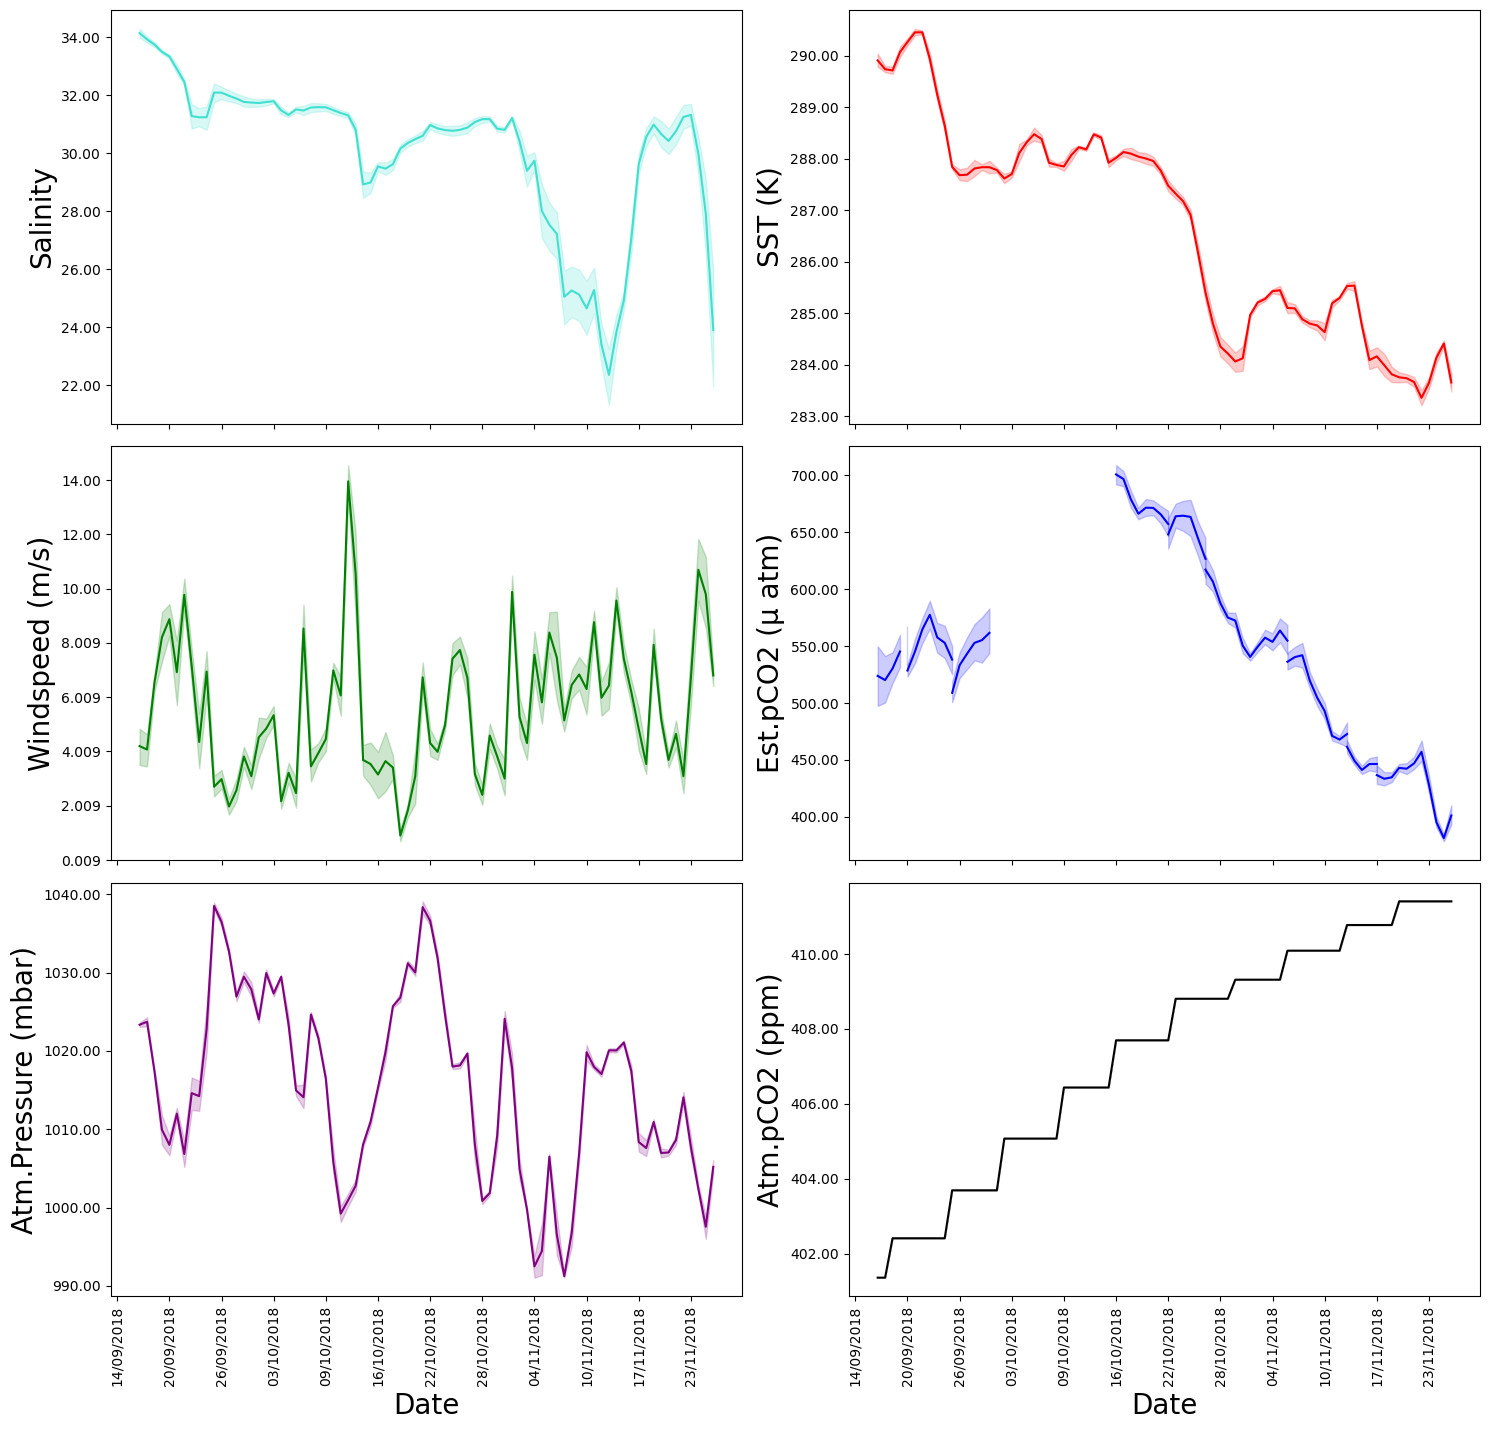

In [5]:
import matplotlib.dates as mdates


# Set up a figure with 4 axes on it. Sharex=True means all axes will share the bottom axes (can help with clarity)
fig,ax = plt.subplots(3,2, sharex=True)
# Set figure height and width
fig.set_figheight(15), fig.set_figwidth(15)

### PLOTTING THE DATA ### (- *s indicate a plot keyword below)
# These Seaborn commands state that we want a *lineplot*, where the *data* is coming 
# from our region_data Dataframe, and we chose the *x* & *y* columns that we want, as well
# as the axis (*ax*) we want to plot on (indexed by 0 at the top and 3 at the bottom)
sns.lineplot(data=region_data, x='Date', y='salinity', color='turquoise', ax=ax[0,0])
sns.lineplot(data=region_data, x='Date', y='sstskin_k', color='red', ax=ax[0,1])
sns.lineplot(data=region_data, x='Date', y='windu10', color='green', ax=ax[1,0])
sns.lineplot(data=region_data, x='Date', y='pco2sw_corr_split', color='orange', ax=ax[1,1], hue=region_data["pco2sw_corr_split"].isna().cumsum(), palette=["blue"]*sum(region_data["pco2sw_corr_split"].isna()), legend=False, markers=True)
sns.lineplot(data=region_data, x='Date', y='pressure_met', color='purple', ax=ax[2, 0])
sns.lineplot(data=region_data, x='Date', y='pco2_air_noaa_2018', color='black', ax=ax[2, 1])

# Use WeekdayLocator and DateFormatter to show only weekly dates on x-axis
date_fmt = mdates.DateFormatter('%d-%m-%Y')
week_locator = mdates.WeekdayLocator(byweekday=mdates.MO)
ax[2,0].xaxis.set_major_locator(week_locator)
ax[2,0].xaxis.set_major_formatter(date_fmt)
ax[2,1].xaxis.set_major_locator(week_locator)
ax[2,1].xaxis.set_major_formatter(date_fmt)

# Set x axis label
ax[2,0].set_xlabel('Date', fontsize = 20) 
ax[2,1].set_xlabel('Date', fontsize = 20) 
ax[2,0].set_xticklabels(region_data['Date'], rotation='vertical')
ax[2,1].set_xticklabels(region_data['Date'], rotation='vertical')

# Set x-axis tick labels
tick_locs = ax[2,0].get_xticks() # Get the current tick locations
ax[2,0].set_xticks(tick_locs) # Set the same tick locations
ax[2,0].set_xticklabels(region_data['Date'][::len(region_data['Date'])//len(tick_locs)][:-1], rotation='vertical')
tick_locs = ax[2,1].get_xticks() # Get the current tick locations
ax[2,1].set_xticks(tick_locs) # Set the same tick locations
ax[2,1].set_xticklabels(region_data['Date'][::len(region_data['Date'])//len(tick_locs)][:-1], rotation='vertical')



# Set y label for each axis
ax[0,0].set_ylabel('Salinity', fontsize = 20) 
ax[0,1].set_ylabel('SST (K)', fontsize = 20)
ax[1,0].set_ylabel('Windspeed (m/s)', fontsize = 20)
ax[1,1].set_ylabel('Est.pCO2 (µ atm)', fontsize = 20)
ax[2, 0].set_ylabel('Atm.Pressure (mbar)', fontsize = 20)
ax[2, 1].set_ylabel('Atm.pCO2 (ppm)', fontsize = 20)

# Changes how axis ticks are displayed for last two axes
# - you can comment these out with # to see the effect when removed
ax[0,0].yaxis.set_major_formatter('{x:9<5.2f}')
ax[0,1].yaxis.set_major_formatter('{x:9<5.2f}')
ax[1,0].yaxis.set_major_formatter('{x:9<5.2f}')
ax[1,1].yaxis.set_major_formatter('{x:9<5.2f}')
ax[2,0].yaxis.set_major_formatter('{x:9<5.2f}')
ax[2,1].yaxis.set_major_formatter('{x:9<5.2f}')

# Set a tight layout to remove extra space around the plots
fig.tight_layout()
# Reduce gap between top of figure and the title
fig.subplots_adjust(top=0.95)

# Show figure!
plt.show()

### Using FluxEngine
To calcualte the air-sea gas fluxes we are going to be using a bulk formulation of the calculation and using the FluxEngine python module toolbox. So lets check to see which version of the FluxEngine we have installed. It should be at least version 4.0.

In [6]:
# We primarily use FluxEngine from the command line, but here we can import it just to check the version
import fluxengine as fe
import fluxengine.tools.lib_text2ncdf as nc
print(fe.__version__)

4.0


Now we need to convert our .tsv data file in the filetype that the FluxEngine uses which is NetCDF. NetCDF is a standard file format used by many scientific and engineering communities and it allows the data to be compressed and the file can contain the metadata that describes how the data were collected, created and processed.

In [7]:
# Converting to netCDF
nc.convert_text_to_netcdf(['merged_draft_final.tsv'],startTime='2018-09-14 00:00:00',endTime='2018-11-30 08:00:00',ncOutPath='merged-drft-ppr.nc',temporalResolution='0 01:00',
    colNames=['salinity', 'sstskin_c', 'sstskin_k', 'windu10', 'windu10_moment2', 'pco2sw_corr_split', 'pressure_met', 'pco2_air_noaa_2018', 'pco2_sst'],
    latProd='Lat',lonProd='Lon',dateIndex=3,parseUnits=False,temporalChunking=1857,limits=[50,51,-6,-5],dateFormatDayFirst=True)

Calculating dimensions.
The following columns will be extracted:
	 salinity
	 sstskin_c
	 sstskin_k
	 windu10
	 windu10_moment2
	 pco2sw_corr_split
	 pressure_met
	 pco2_air_noaa_2018
	 pco2_sst
Processing data in file merged_draft_final.tsv


/Users/sayooj/opt/anaconda3/envs/fe_work_env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/sayooj/opt/anaconda3/envs/fe_work_env/lib/python3.7/site-packages/fluxengine/tools/lib_text2ncdf.py:98: RuntimeWarning: Mean of empty slice
  output[coords] = np.nanmean(vals);


Writing output netCDF file(s)...
Finished converting text file to netCDF3. There were 0 values which fell outside the specified lat/lon or start/stop time boundaries.
Number of missing values found: 0


We now have our NetCDF (version 3) file and we can now use the FluxEngine to calculate the air-sea gas fluxes.

In [8]:
# Running FluxEngine
!fe_run.py "draft_new.conf" -s "2018-09-14" -e "2018-12-01" -l 

Executing on 'Sayoojs-MacBook-Air-98.local' at 06/03/2023 13:49:52
Parsing settings file at: /Users/sayooj/opt/anaconda3/envs/fe_work_env/lib/python3.7/site-packages/fluxengine/core/settings.xml
(ofluxghg_flux_calc, FluxEngine._load_lon_lat_time): Grid dimensions set to: (1, 1)
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) Using the saline skin model (0.100000 psu added to skin salinities)
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) SST gradient handling is on, using SSTskin and SSTfnd = SSTskin + 0.170000 for flux calculation (ignoring SSTfnd data in configuration file).
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) Using the RAPID model (from Woolf et al., 2016)
(rate_parameterisation.py: k_Nightingale2000.__call__) Using the Nightingale et al., 2000 (N00) k parameterisation
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) SUCCESS writing file /Users/sayooj/Downloads/FE_FalEstuary_output_Autumn2018gf.nc
Flux engine exited with exit code: 0
14 Sep 2018 00:00:00 complete

(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) Using the saline skin model (0.100000 psu added to skin salinities)
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) SST gradient handling is on, using SSTskin and SSTfnd = SSTskin + 0.170000 for flux calculation (ignoring SSTfnd data in configuration file).
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) Using the RAPID model (from Woolf et al., 2016)
(rate_parameterisation.py: k_Nightingale2000.__call__) Using the Nightingale et al., 2000 (N00) k parameterisation
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) SUCCESS writing file /Users/sayooj/Downloads/FE_FalEstuary_output_Autumn2018gf.nc
Flux engine exited with exit code: 0
23 Sep 2018 00:00:00 completed successfully.

Parsing settings file at: /Users/sayooj/opt/anaconda3/envs/fe_work_env/lib/python3.7/site-packages/fluxengine/core/settings.xml
(ofluxghg_flux_calc, FluxEngine._load_lon_lat_time): Grid dimensions set to: (1, 1)
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) 

(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) Using the saline skin model (0.100000 psu added to skin salinities)
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) SST gradient handling is on, using SSTskin and SSTfnd = SSTskin + 0.170000 for flux calculation (ignoring SSTfnd data in configuration file).
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) Using the RAPID model (from Woolf et al., 2016)
(rate_parameterisation.py: k_Nightingale2000.__call__) Using the Nightingale et al., 2000 (N00) k parameterisation
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) SUCCESS writing file /Users/sayooj/Downloads/FE_FalEstuary_output_Autumn2018gf.nc
Flux engine exited with exit code: 0
02 Oct 2018 00:00:00 completed successfully.

Parsing settings file at: /Users/sayooj/opt/anaconda3/envs/fe_work_env/lib/python3.7/site-packages/fluxengine/core/settings.xml
(ofluxghg_flux_calc, FluxEngine._load_lon_lat_time): Grid dimensions set to: (1, 1)
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) 

(ofluxghg_flux_calc, FluxEngine._load_lon_lat_time): Grid dimensions set to: (1, 1)
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) Using the saline skin model (0.100000 psu added to skin salinities)
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) SST gradient handling is on, using SSTskin and SSTfnd = SSTskin + 0.170000 for flux calculation (ignoring SSTfnd data in configuration file).
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) Using the RAPID model (from Woolf et al., 2016)
(rate_parameterisation.py: k_Nightingale2000.__call__) Using the Nightingale et al., 2000 (N00) k parameterisation
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) SUCCESS writing file /Users/sayooj/Downloads/FE_FalEstuary_output_Autumn2018gf.nc
Flux engine exited with exit code: 0
11 Oct 2018 00:00:00 completed successfully.

Parsing settings file at: /Users/sayooj/opt/anaconda3/envs/fe_work_env/lib/python3.7/site-packages/fluxengine/core/settings.xml
(ofluxghg_flux_calc, FluxEngine._load_lon_lat_time

(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) Using the saline skin model (0.100000 psu added to skin salinities)
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) SST gradient handling is on, using SSTskin and SSTfnd = SSTskin + 0.170000 for flux calculation (ignoring SSTfnd data in configuration file).
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) Using the RAPID model (from Woolf et al., 2016)
(rate_parameterisation.py: k_Nightingale2000.__call__) Using the Nightingale et al., 2000 (N00) k parameterisation
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) SUCCESS writing file /Users/sayooj/Downloads/FE_FalEstuary_output_Autumn2018gf.nc
Flux engine exited with exit code: 0
20 Oct 2018 00:00:00 completed successfully.

Parsing settings file at: /Users/sayooj/opt/anaconda3/envs/fe_work_env/lib/python3.7/site-packages/fluxengine/core/settings.xml
(ofluxghg_flux_calc, FluxEngine._load_lon_lat_time): Grid dimensions set to: (1, 1)
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) 

(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) Using the saline skin model (0.100000 psu added to skin salinities)
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) SST gradient handling is on, using SSTskin and SSTfnd = SSTskin + 0.170000 for flux calculation (ignoring SSTfnd data in configuration file).
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) Using the RAPID model (from Woolf et al., 2016)
(rate_parameterisation.py: k_Nightingale2000.__call__) Using the Nightingale et al., 2000 (N00) k parameterisation
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) SUCCESS writing file /Users/sayooj/Downloads/FE_FalEstuary_output_Autumn2018gf.nc
Flux engine exited with exit code: 0
29 Oct 2018 00:00:00 completed successfully.

Parsing settings file at: /Users/sayooj/opt/anaconda3/envs/fe_work_env/lib/python3.7/site-packages/fluxengine/core/settings.xml
(ofluxghg_flux_calc, FluxEngine._load_lon_lat_time): Grid dimensions set to: (1, 1)
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) 

(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) Using the saline skin model (0.100000 psu added to skin salinities)
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) SST gradient handling is on, using SSTskin and SSTfnd = SSTskin + 0.170000 for flux calculation (ignoring SSTfnd data in configuration file).
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) Using the RAPID model (from Woolf et al., 2016)
(rate_parameterisation.py: k_Nightingale2000.__call__) Using the Nightingale et al., 2000 (N00) k parameterisation
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) SUCCESS writing file /Users/sayooj/Downloads/FE_FalEstuary_output_Autumn2018gf.nc
Flux engine exited with exit code: 0
07 Nov 2018 00:00:00 completed successfully.

Parsing settings file at: /Users/sayooj/opt/anaconda3/envs/fe_work_env/lib/python3.7/site-packages/fluxengine/core/settings.xml
(ofluxghg_flux_calc, FluxEngine._load_lon_lat_time): Grid dimensions set to: (1, 1)
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) 

(ofluxghg_flux_calc, FluxEngine._load_lon_lat_time): Grid dimensions set to: (1, 1)
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) Using the saline skin model (0.100000 psu added to skin salinities)
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) SST gradient handling is on, using SSTskin and SSTfnd = SSTskin + 0.170000 for flux calculation (ignoring SSTfnd data in configuration file).
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) Using the RAPID model (from Woolf et al., 2016)
(rate_parameterisation.py: k_Nightingale2000.__call__) Using the Nightingale et al., 2000 (N00) k parameterisation
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) SUCCESS writing file /Users/sayooj/Downloads/FE_FalEstuary_output_Autumn2018gf.nc
Flux engine exited with exit code: 0
16 Nov 2018 00:00:00 completed successfully.

Parsing settings file at: /Users/sayooj/opt/anaconda3/envs/fe_work_env/lib/python3.7/site-packages/fluxengine/core/settings.xml
(ofluxghg_flux_calc, FluxEngine._load_lon_lat_time

(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) Using the saline skin model (0.100000 psu added to skin salinities)
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) SST gradient handling is on, using SSTskin and SSTfnd = SSTskin + 0.170000 for flux calculation (ignoring SSTfnd data in configuration file).
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) Using the RAPID model (from Woolf et al., 2016)
(rate_parameterisation.py: k_Nightingale2000.__call__) Using the Nightingale et al., 2000 (N00) k parameterisation
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) SUCCESS writing file /Users/sayooj/Downloads/FE_FalEstuary_output_Autumn2018gf.nc
Flux engine exited with exit code: 0
25 Nov 2018 00:00:00 completed successfully.

Parsing settings file at: /Users/sayooj/opt/anaconda3/envs/fe_work_env/lib/python3.7/site-packages/fluxengine/core/settings.xml
(ofluxghg_flux_calc, FluxEngine._load_lon_lat_time): Grid dimensions set to: (1, 1)
(ofluxghg_flux_calc, FluxEngine._run_fluxengine_) 

The 'completed successfully' message means that we now have the air-sea gas fluxes calculated from the Fal mooring data. The output is currently in a NetCDF file. You can view this using Panoply which is data viewer developed and provided for free by NASA. Alternatively we can extract the data from the NetCDF file and store it back into our original .tsv file as additional columns of data.

In [9]:
# Appending FluxEngine results
!fe_append2insitu.py "FE_FalEstuary_output_Autumn2018gf.nc" "merged_draft_final.tsv" "draft_estuary.tsv" --varsToAppend "OF" "OK3" "OSFC" "OIC1" --dateIndex 3 --lonCol "Lon" --latCol "Lat" 


Combining files at  FE_FalEstuary_output_Autumn2018gf.nc and merged_draft_final.tsv
Row 409 Warning: No data found for timestep -247 lat 50.216161 lon -5.027979. nan inserted instead
Row 409 Warning: No data found for timestep -247 lat 50.216161 lon -5.027979. nan inserted instead
Row 409 Warning: No data found for timestep -247 lat 50.216161 lon -5.027979. nan inserted instead
Row 409 Warning: No data found for timestep -247 lat 50.216161 lon -5.027979. nan inserted instead
Row 410 Warning: No data found for timestep -247 lat 50.216161 lon -5.027979. nan inserted instead
Row 410 Warning: No data found for timestep -247 lat 50.216161 lon -5.027979. nan inserted instead
Row 410 Warning: No data found for timestep -247 lat 50.216161 lon -5.027979. nan inserted instead
Row 410 Warning: No data found for timestep -247 lat 50.216161 lon -5.027979. nan inserted instead
Row 411 Warning: No data found for timestep -247 lat 50.216161 lon -5.027979. nan inserted instead
Row 411 Warning: No data 

Row 453 Warning: No data found for timestep -216 lat 50.216161 lon -5.027979. nan inserted instead
Row 454 Warning: No data found for timestep -216 lat 50.216161 lon -5.027979. nan inserted instead
Row 454 Warning: No data found for timestep -216 lat 50.216161 lon -5.027979. nan inserted instead
Row 454 Warning: No data found for timestep -216 lat 50.216161 lon -5.027979. nan inserted instead
Row 454 Warning: No data found for timestep -216 lat 50.216161 lon -5.027979. nan inserted instead
Row 455 Warning: No data found for timestep -216 lat 50.216161 lon -5.027979. nan inserted instead
Row 455 Warning: No data found for timestep -216 lat 50.216161 lon -5.027979. nan inserted instead
Row 455 Warning: No data found for timestep -216 lat 50.216161 lon -5.027979. nan inserted instead
Row 455 Warning: No data found for timestep -216 lat 50.216161 lon -5.027979. nan inserted instead
Row 456 Warning: No data found for timestep -216 lat 50.216161 lon -5.027979. nan inserted instead
Row 456 Wa

Row 486 Warning: No data found for timestep -157 lat 50.216161 lon -5.027979. nan inserted instead
Row 486 Warning: No data found for timestep -157 lat 50.216161 lon -5.027979. nan inserted instead
Row 486 Warning: No data found for timestep -157 lat 50.216161 lon -5.027979. nan inserted instead
Row 486 Warning: No data found for timestep -157 lat 50.216161 lon -5.027979. nan inserted instead
Row 487 Warning: No data found for timestep -157 lat 50.216161 lon -5.027979. nan inserted instead
Row 487 Warning: No data found for timestep -157 lat 50.216161 lon -5.027979. nan inserted instead
Row 487 Warning: No data found for timestep -157 lat 50.216161 lon -5.027979. nan inserted instead
Row 487 Warning: No data found for timestep -157 lat 50.216161 lon -5.027979. nan inserted instead
Row 488 Warning: No data found for timestep -157 lat 50.216161 lon -5.027979. nan inserted instead
Row 488 Warning: No data found for timestep -157 lat 50.216161 lon -5.027979. nan inserted instead
Row 488 Wa

Row 518 Warning: No data found for timestep -127 lat 50.216161 lon -5.027979. nan inserted instead
Row 518 Warning: No data found for timestep -127 lat 50.216161 lon -5.027979. nan inserted instead
Row 519 Warning: No data found for timestep -127 lat 50.216161 lon -5.027979. nan inserted instead
Row 519 Warning: No data found for timestep -127 lat 50.216161 lon -5.027979. nan inserted instead
Row 519 Warning: No data found for timestep -127 lat 50.216161 lon -5.027979. nan inserted instead
Row 519 Warning: No data found for timestep -127 lat 50.216161 lon -5.027979. nan inserted instead
Row 520 Warning: No data found for timestep -127 lat 50.216161 lon -5.027979. nan inserted instead
Row 520 Warning: No data found for timestep -127 lat 50.216161 lon -5.027979. nan inserted instead
Row 520 Warning: No data found for timestep -127 lat 50.216161 lon -5.027979. nan inserted instead
Row 520 Warning: No data found for timestep -127 lat 50.216161 lon -5.027979. nan inserted instead
Row 521 Wa

Row 550 Warning: No data found for timestep -96 lat 50.216161 lon -5.027979. nan inserted instead
Row 550 Warning: No data found for timestep -96 lat 50.216161 lon -5.027979. nan inserted instead
Row 550 Warning: No data found for timestep -96 lat 50.216161 lon -5.027979. nan inserted instead
Row 551 Warning: No data found for timestep -96 lat 50.216161 lon -5.027979. nan inserted instead
Row 551 Warning: No data found for timestep -96 lat 50.216161 lon -5.027979. nan inserted instead
Row 551 Warning: No data found for timestep -96 lat 50.216161 lon -5.027979. nan inserted instead
Row 551 Warning: No data found for timestep -96 lat 50.216161 lon -5.027979. nan inserted instead
Row 552 Warning: No data found for timestep -96 lat 50.216161 lon -5.027979. nan inserted instead
Row 552 Warning: No data found for timestep -96 lat 50.216161 lon -5.027979. nan inserted instead
Row 552 Warning: No data found for timestep -96 lat 50.216161 lon -5.027979. nan inserted instead
Row 552 Warning: No 

Row 582 Warning: No data found for timestep -35 lat 50.216161 lon -5.027979. nan inserted instead
Row 583 Warning: No data found for timestep -35 lat 50.216161 lon -5.027979. nan inserted instead
Row 583 Warning: No data found for timestep -35 lat 50.216161 lon -5.027979. nan inserted instead
Row 583 Warning: No data found for timestep -35 lat 50.216161 lon -5.027979. nan inserted instead
Row 583 Warning: No data found for timestep -35 lat 50.216161 lon -5.027979. nan inserted instead
Row 584 Warning: No data found for timestep -35 lat 50.216161 lon -5.027979. nan inserted instead
Row 584 Warning: No data found for timestep -35 lat 50.216161 lon -5.027979. nan inserted instead
Row 584 Warning: No data found for timestep -35 lat 50.216161 lon -5.027979. nan inserted instead
Row 584 Warning: No data found for timestep -35 lat 50.216161 lon -5.027979. nan inserted instead
Row 585 Warning: No data found for timestep -35 lat 50.216161 lon -5.027979. nan inserted instead
Row 585 Warning: No 

Row 615 Warning: No data found for timestep -4 lat 50.216161 lon -5.027979. nan inserted instead
Row 615 Warning: No data found for timestep -4 lat 50.216161 lon -5.027979. nan inserted instead
Row 615 Warning: No data found for timestep -4 lat 50.216161 lon -5.027979. nan inserted instead
Row 615 Warning: No data found for timestep -4 lat 50.216161 lon -5.027979. nan inserted instead
Row 616 Warning: No data found for timestep -4 lat 50.216161 lon -5.027979. nan inserted instead
Row 616 Warning: No data found for timestep -4 lat 50.216161 lon -5.027979. nan inserted instead
Row 616 Warning: No data found for timestep -4 lat 50.216161 lon -5.027979. nan inserted instead
Row 616 Warning: No data found for timestep -4 lat 50.216161 lon -5.027979. nan inserted instead
Row 617 Warning: No data found for timestep -4 lat 50.216161 lon -5.027979. nan inserted instead
Row 617 Warning: No data found for timestep -4 lat 50.216161 lon -5.027979. nan inserted instead
Row 617 Warning: No data found

Row 687 Warning: No data found for timestep 87 lat 50.216161 lon -5.027979. nan inserted instead
Row 687 Warning: No data found for timestep 87 lat 50.216161 lon -5.027979. nan inserted instead
Row 687 Warning: No data found for timestep 87 lat 50.216161 lon -5.027979. nan inserted instead
Row 688 Warning: No data found for timestep 87 lat 50.216161 lon -5.027979. nan inserted instead
Row 688 Warning: No data found for timestep 87 lat 50.216161 lon -5.027979. nan inserted instead
Row 688 Warning: No data found for timestep 87 lat 50.216161 lon -5.027979. nan inserted instead
Row 688 Warning: No data found for timestep 87 lat 50.216161 lon -5.027979. nan inserted instead
Row 689 Warning: No data found for timestep 87 lat 50.216161 lon -5.027979. nan inserted instead
Row 689 Warning: No data found for timestep 87 lat 50.216161 lon -5.027979. nan inserted instead
Row 689 Warning: No data found for timestep 87 lat 50.216161 lon -5.027979. nan inserted instead
Row 689 Warning: No data found

Row 1185 Warning: No data found for timestep -215 lat 50.216161 lon -5.027979. nan inserted instead
Row 1185 Warning: No data found for timestep -215 lat 50.216161 lon -5.027979. nan inserted instead
Row 1185 Warning: No data found for timestep -215 lat 50.216161 lon -5.027979. nan inserted instead
Row 1186 Warning: No data found for timestep -215 lat 50.216161 lon -5.027979. nan inserted instead
Row 1186 Warning: No data found for timestep -215 lat 50.216161 lon -5.027979. nan inserted instead
Row 1186 Warning: No data found for timestep -215 lat 50.216161 lon -5.027979. nan inserted instead
Row 1186 Warning: No data found for timestep -215 lat 50.216161 lon -5.027979. nan inserted instead
Row 1187 Warning: No data found for timestep -215 lat 50.216161 lon -5.027979. nan inserted instead
Row 1187 Warning: No data found for timestep -215 lat 50.216161 lon -5.027979. nan inserted instead
Row 1187 Warning: No data found for timestep -215 lat 50.216161 lon -5.027979. nan inserted instead


Row 1217 Warning: No data found for timestep -187 lat 50.216161 lon -5.027979. nan inserted instead
Row 1217 Warning: No data found for timestep -187 lat 50.216161 lon -5.027979. nan inserted instead
Row 1218 Warning: No data found for timestep -187 lat 50.216161 lon -5.027979. nan inserted instead
Row 1218 Warning: No data found for timestep -187 lat 50.216161 lon -5.027979. nan inserted instead
Row 1218 Warning: No data found for timestep -187 lat 50.216161 lon -5.027979. nan inserted instead
Row 1218 Warning: No data found for timestep -187 lat 50.216161 lon -5.027979. nan inserted instead
Row 1219 Warning: No data found for timestep -187 lat 50.216161 lon -5.027979. nan inserted instead
Row 1219 Warning: No data found for timestep -187 lat 50.216161 lon -5.027979. nan inserted instead
Row 1219 Warning: No data found for timestep -187 lat 50.216161 lon -5.027979. nan inserted instead
Row 1219 Warning: No data found for timestep -187 lat 50.216161 lon -5.027979. nan inserted instead


Row 1248 Warning: No data found for timestep -156 lat 50.216161 lon -5.027979. nan inserted instead
Row 1248 Warning: No data found for timestep -156 lat 50.216161 lon -5.027979. nan inserted instead
Row 1249 Warning: No data found for timestep -126 lat 50.216161 lon -5.027979. nan inserted instead
Row 1249 Warning: No data found for timestep -126 lat 50.216161 lon -5.027979. nan inserted instead
Row 1249 Warning: No data found for timestep -126 lat 50.216161 lon -5.027979. nan inserted instead
Row 1249 Warning: No data found for timestep -126 lat 50.216161 lon -5.027979. nan inserted instead
Row 1250 Warning: No data found for timestep -126 lat 50.216161 lon -5.027979. nan inserted instead
Row 1250 Warning: No data found for timestep -126 lat 50.216161 lon -5.027979. nan inserted instead
Row 1250 Warning: No data found for timestep -126 lat 50.216161 lon -5.027979. nan inserted instead
Row 1250 Warning: No data found for timestep -126 lat 50.216161 lon -5.027979. nan inserted instead


Row 1280 Warning: No data found for timestep -95 lat 50.216161 lon -5.027979. nan inserted instead
Row 1281 Warning: No data found for timestep -95 lat 50.216161 lon -5.027979. nan inserted instead
Row 1281 Warning: No data found for timestep -95 lat 50.216161 lon -5.027979. nan inserted instead
Row 1281 Warning: No data found for timestep -95 lat 50.216161 lon -5.027979. nan inserted instead
Row 1281 Warning: No data found for timestep -95 lat 50.216161 lon -5.027979. nan inserted instead
Row 1282 Warning: No data found for timestep -95 lat 50.216161 lon -5.027979. nan inserted instead
Row 1282 Warning: No data found for timestep -95 lat 50.216161 lon -5.027979. nan inserted instead
Row 1282 Warning: No data found for timestep -95 lat 50.216161 lon -5.027979. nan inserted instead
Row 1282 Warning: No data found for timestep -95 lat 50.216161 lon -5.027979. nan inserted instead
Row 1283 Warning: No data found for timestep -95 lat 50.216161 lon -5.027979. nan inserted instead
Row 1283 W

Row 1313 Warning: No data found for timestep -65 lat 50.216161 lon -5.027979. nan inserted instead
Row 1313 Warning: No data found for timestep -65 lat 50.216161 lon -5.027979. nan inserted instead
Row 1313 Warning: No data found for timestep -65 lat 50.216161 lon -5.027979. nan inserted instead
Row 1313 Warning: No data found for timestep -65 lat 50.216161 lon -5.027979. nan inserted instead
Row 1314 Warning: No data found for timestep -65 lat 50.216161 lon -5.027979. nan inserted instead
Row 1314 Warning: No data found for timestep -65 lat 50.216161 lon -5.027979. nan inserted instead
Row 1314 Warning: No data found for timestep -65 lat 50.216161 lon -5.027979. nan inserted instead
Row 1314 Warning: No data found for timestep -65 lat 50.216161 lon -5.027979. nan inserted instead
Row 1315 Warning: No data found for timestep -65 lat 50.216161 lon -5.027979. nan inserted instead
Row 1315 Warning: No data found for timestep -65 lat 50.216161 lon -5.027979. nan inserted instead
Row 1315 W

Row 1345 Warning: No data found for timestep -3 lat 50.216161 lon -5.027979. nan inserted instead
Row 1345 Warning: No data found for timestep -3 lat 50.216161 lon -5.027979. nan inserted instead
Row 1346 Warning: No data found for timestep -3 lat 50.216161 lon -5.027979. nan inserted instead
Row 1346 Warning: No data found for timestep -3 lat 50.216161 lon -5.027979. nan inserted instead
Row 1346 Warning: No data found for timestep -3 lat 50.216161 lon -5.027979. nan inserted instead
Row 1346 Warning: No data found for timestep -3 lat 50.216161 lon -5.027979. nan inserted instead
Row 1347 Warning: No data found for timestep -3 lat 50.216161 lon -5.027979. nan inserted instead
Row 1347 Warning: No data found for timestep -3 lat 50.216161 lon -5.027979. nan inserted instead
Row 1347 Warning: No data found for timestep -3 lat 50.216161 lon -5.027979. nan inserted instead
Row 1347 Warning: No data found for timestep -3 lat 50.216161 lon -5.027979. nan inserted instead
Row 1348 Warning: No

Row 1417 Warning: No data found for timestep 88 lat 50.216161 lon -5.027979. nan inserted instead
Row 1417 Warning: No data found for timestep 88 lat 50.216161 lon -5.027979. nan inserted instead
Row 1417 Warning: No data found for timestep 88 lat 50.216161 lon -5.027979. nan inserted instead
Row 1417 Warning: No data found for timestep 88 lat 50.216161 lon -5.027979. nan inserted instead
Row 1418 Warning: No data found for timestep 88 lat 50.216161 lon -5.027979. nan inserted instead
Row 1418 Warning: No data found for timestep 88 lat 50.216161 lon -5.027979. nan inserted instead
Row 1418 Warning: No data found for timestep 88 lat 50.216161 lon -5.027979. nan inserted instead
Row 1418 Warning: No data found for timestep 88 lat 50.216161 lon -5.027979. nan inserted instead
Row 1419 Warning: No data found for timestep 88 lat 50.216161 lon -5.027979. nan inserted instead
Row 1419 Warning: No data found for timestep 88 lat 50.216161 lon -5.027979. nan inserted instead
Row 1419 Warning: No

Finished merging ['OF', 'OK3', 'OSFC', 'OIC1'] from FE_FalEstuary_output_Autumn2018gf.nc with merged_draft_final.tsv
Output written to draft_estuary.tsv


We can easily view and plot the air-sea CO 2  gas flux results using some simple python plotting routines.

In [10]:
# Load merged data
merged_data = pd.read_csv('draft_estuary.tsv', sep='\t',index_col=0).reset_index(drop=True)

In [11]:
# View top of merged data
merged_data.head()

,Lon,Lat,Datetime,Date,Year,Month,Day,Hour,Minute,Second,...,windu10,windu10_moment2,pco2sw_corr_split,pressure_met,pco2_air_noaa_2018,pco2_sst,OF [g C m-2 day-1],OK3 [cm h-1],OSFC [g m-3],OIC1 [g m-3]
0,-5.027979,50.216161,2018-09-14 00:00:00,14/09/2018,2018,9,14,0,0,0,...,2.057613,4.233772,500.019450,1024.1,401.3573,16.642000,0.014376,1.420482,0.212905,0.170735
1,-5.027979,50.216161,2018-09-14 00:00:00,14/09/2018,2018,9,14,0,0,0,...,2.057613,4.233772,488.055048,1024.1,401.3573,16.642000,0.014376,1.420482,0.212905,0.170735
2,-5.027979,50.216161,2018-09-14 01:00:00,14/09/2018,2018,9,14,1,0,0,...,2.057613,4.233772,550.944840,1023.9,401.3573,16.598000,0.014376,1.420482,0.212905,0.170735
3,-5.027979,50.216161,2018-09-14 02:00:00,14/09/2018,2018,9,14,2,0,0,...,2.572016,6.615269,588.035046,1023.5,401.3573,16.514667,0.014376,1.420482,0.212905,0.170735
4,-5.027979,50.216161,2018-09-14 03:00:00,14/09/2018,2018,9,14,3,0,0,...,2.572016,6.615269,627.313939,1022.9,401.3573,16.463000,0.014376,1.420482,0.212905,0.170735


We need to add out 'Days_since' to this new merged dataframe:

In [12]:
# Initialise the new Dataframe column and fill with a hold value
merged_data['Days_since'] = 'hold value'

# Produce a datetime object for the first recording 
# - the zeros in the line below show it's the first row (index starts at zero)
start_date = dt.datetime(merged_data.loc[0,'Year'],merged_data.loc[0,'Month'],merged_data.loc[0,'Day'],
                            merged_data.loc[0,'Hour'],merged_data.loc[0,'Minute'],merged_data.loc[0,'Second'])

# Loop over all rows in the Dataframe - i.e from 0 to the length of the Dataframe
for i in range(0,len(merged_data)):
    # Get the date time object for the currently indexed recording - indexed by i
    future_date = dt.datetime(merged_data.loc[i,'Year'],merged_data.loc[i,'Month'],merged_data.loc[i,'Day'],
                              merged_data.loc[i,'Hour'],merged_data.loc[i,'Minute'],merged_data.loc[i,'Second'])
    
    # Find difference between current datetime and inital datetime
    day_diff = future_date - start_date
    
    # Fill Dataframe column with time difference in seconds (found using .total_seconds()) 
    # divided by 86400 (proportion of days that have passed)
    merged_data.loc[i,'Days_since'] = day_diff.total_seconds()/(60*60*24)

In [13]:
# Show section of 'Days_since' column for visual check
merged_data[['Datetime', 'Days_since']].head(5)

,Datetime,Days_since
0,2018-09-14 00:00:00,0.0
1,2018-09-14 00:00:00,0.0
2,2018-09-14 01:00:00,0.041667
3,2018-09-14 02:00:00,0.083333
4,2018-09-14 03:00:00,0.125


### Plot the Flux

/Users/sayooj/opt/anaconda3/envs/fe_work_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: 
The palette list has fewer values (480) than needed (481) and will cycle, which may produce an uninterpretable plot.
  """


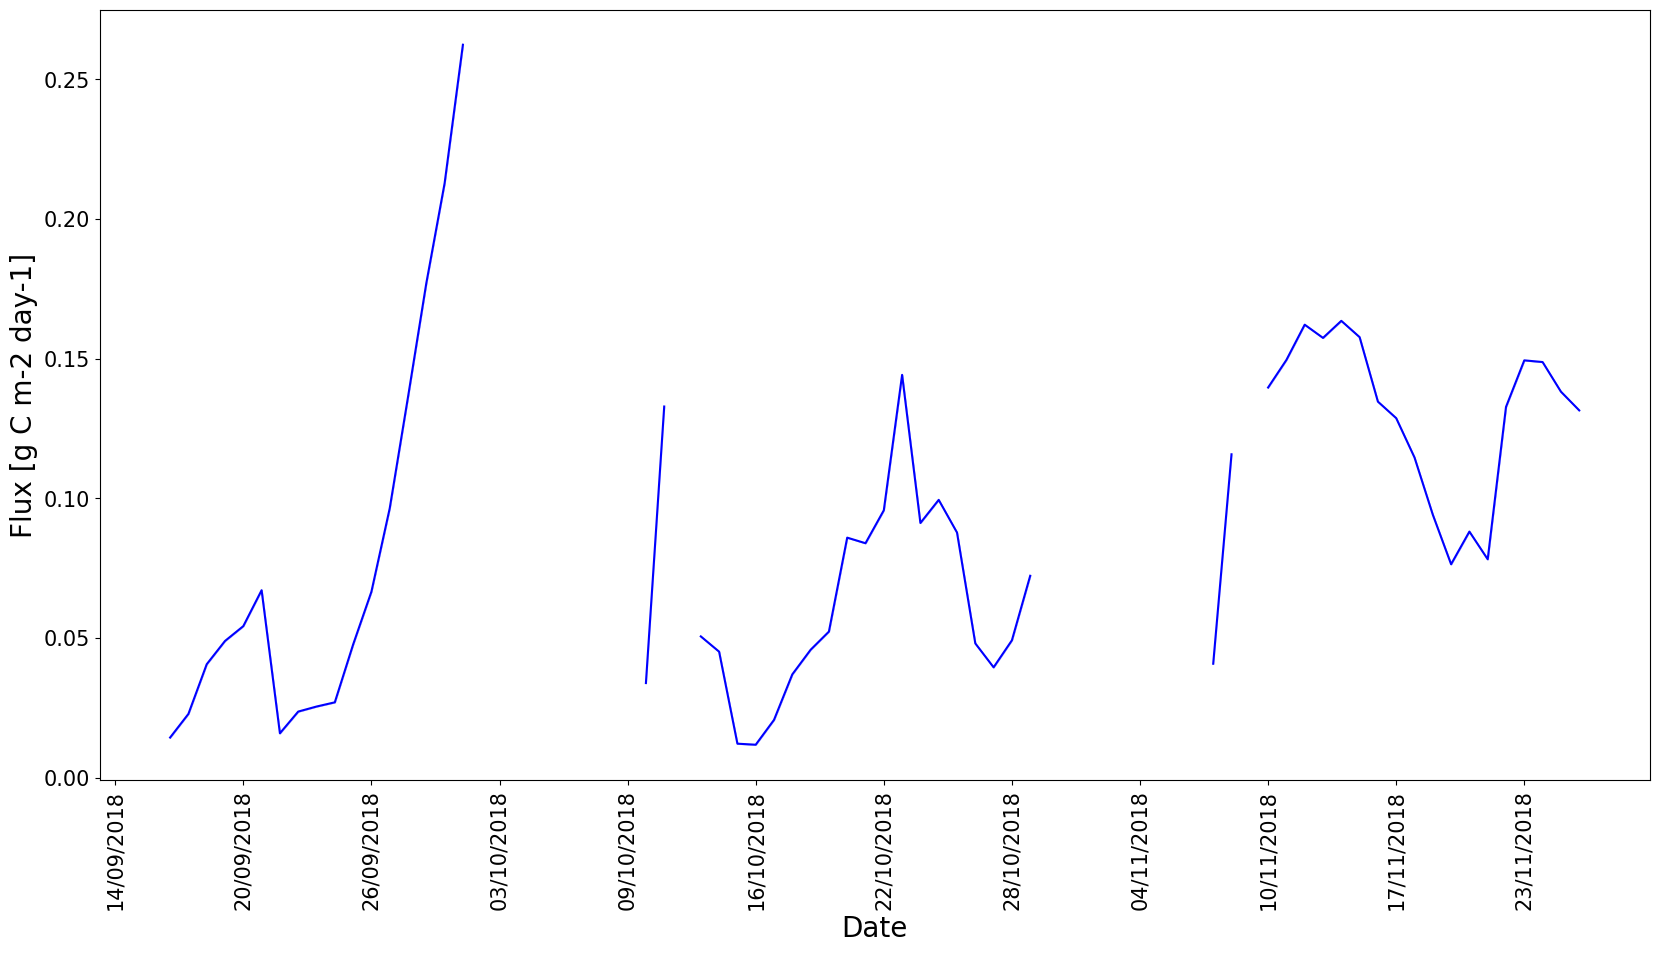

In [14]:
# Set up a figure with 1 axes
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(20, 10))

# Plot data on the ax object
sns.lineplot(data=merged_data, x='Date', y='OF [g C m-2 day-1]', hue=merged_data["OF [g C m-2 day-1]"].isna().cumsum(), palette=["blue"]*sum(merged_data["OF [g C m-2 day-1]"].isna()), legend=False, markers=True, ax=ax)

# Set plot features 
plt.xlabel(f'Days since {merged_data.loc[0,"Datetime"]}', fontdict={'size':20})
plt.ylabel('Flux [g C m-2 day-1]', fontdict={'size':20})
plt.tick_params(labelsize=15)

# Use WeekdayLocator and DateFormatter to show only weekly dates on x-axis
date_fmt = mdates.DateFormatter('%d-%m-%Y')
week_locator = mdates.WeekdayLocator(byweekday=mdates.MO)
ax.xaxis.set_major_locator(week_locator)
ax.xaxis.set_major_formatter(date_fmt)

# Set x-axis tick labels
tick_locs = ax.get_xticks() # Get the current tick locations
ax.set_xticks(tick_locs) # Set the same tick locations
ax.set_xticklabels(merged_data['Date'][::len(merged_data['Date'])//len(tick_locs)][:-1], rotation='vertical')

# Set x axis label
ax.set_xlabel('Date', fontsize=20) 

# Show figure!
plt.show()